In [1]:
# Display the avg location of a particular structure in the mean shape of the matched dataset

In [2]:
!date

Thu Apr 27 09:09:21 PDT 2023


In [3]:
!which python

/home/matheus.viana/anaconda3/envs/lab-variance/bin/python


In [4]:
!pip list | grep cvapipe

cvapipe-analysis           0.1.0                                                         /allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis


In [5]:
import os
import sys
import json
import importlib
import concurrent
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [7]:
genes = ["SARC", "FRET", "ADH"]

In [9]:
datasets = {
    "pca62": {
        "control": "/allen/aics/assay-dev/MicroscopyOtherData/Viana/datasets/AbbyCardios/staging_pca9",
        "perturbed": "/allen/aics/assay-dev/MicroscopyOtherData/Viana/datasets/AbbyCardios/staging_pca62"
    }}

In [10]:
importlib.reload(common)

<module 'common' from '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/notebooks/FigureEdges/../tools/common.py'>

In [11]:
data = {}
for ds, named_staging in datasets.items():
    for dsname, staging in named_staging.items():
    
        control, device = common.get_managers_from_staging_path(staging)
    
        inner_alias = control.get_inner_most_alias_to_parameterize()
        outer_alias = control.get_outer_most_alias_to_parameterize()
        inner_mesh = device.read_vtk_polydata(f"avgshape/{ds}_{inner_alias}_matched.vtk")
        outer_mesh = device.read_vtk_polydata(f"avgshape/{ds}_{outer_alias}_matched.vtk")

        row = pd.Series({"shape_mode": "NUC_MEM_PC1", "mpId": 1, "aggtype": "avg", "alias": "STR"})
        domain, domain_nuc, domain_mem, coords_param = common.get_map_point_shape(control, device, row, inner_mesh=inner_mesh, outer_mesh=outer_mesh)

        morphs = {}
        for gene in genes:
            row["structure"] = gene
            rep = device.read_agg_parameterized_intensity(row)
            morphed = cytoparam.morph_representation_on_shape(
                img=domain,
                param_img_coords=coords_param,
                representation=rep
            )
            morphed = np.stack([domain_nuc, domain_mem, morphed], axis=0)
            morphs[gene] = morphed
        data[dsname] = morphs

/home/matheus.viana/anaconda3/envs/lab-variance/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
/home/matheus.viana/anaconda3/envs/lab-variance/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)
/home/matheus.viana/anaconda3/envs/lab-variance/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The de

In [12]:
mode = {"nuc": "center_nuc", "mem": "center_nuc", "gfp": "center_nuc"}
args = {"gridspec_kw": {"hspace": 0, "wspace": 0}, "sharex": True, "sharey": True}

In [13]:
gene = genes[0]

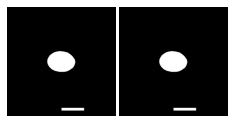

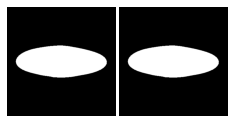

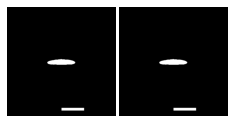

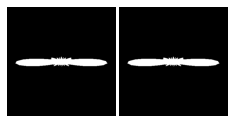

In [14]:
for orient in ["z", "y"]:
    for alias in ["nuc", "mem"]:
        fig, axs = plt.subplots(1,2, figsize=(4, 2), **args)
        for ax, (pheno, instance) in zip(axs, data.items()):
            ax.axis("off")
            proj = common.Projector(instance[gene], box_size=400)
            proj.set_projection_mode(ax=orient, mode=mode)
            proj.project_on(alias=alias, ax=ax, scale_bar={"pixel_size":0.18, "length":15})
        plt.savefig(f"FigureEdges2_{gene}_{alias}_{orient}.png", dpi=150)
        plt.show()

In [15]:
orients = ["z", "y"]
vmax = 60#np.max([contrast[gene][ax][1] for ax in orients])

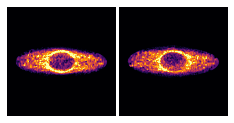

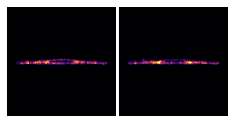

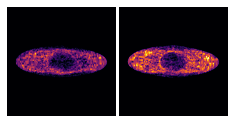

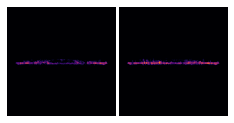

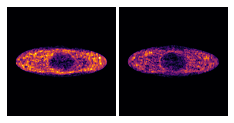

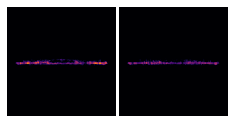

In [16]:
for gene in genes:
    for orient in orients:
        fig, axs = plt.subplots(1,2, figsize=(4, 2), **args)
        for ax, (pheno, instance) in zip(axs, data.items()):
            ax.axis("off")
            proj = common.Projector(instance[gene], box_size=400)
            proj.set_projection_mode(ax=orient, mode=mode)
            proj.set_vmin_vmax_gfp_values(0, vmax)
            view = proj.project_on(alias="gfp", ax=ax)
        plt.savefig(f"FigureEdges2_{gene}_gfp_{orient}.png", dpi=150)
        plt.show()

In [17]:
common.now("complete")

complete 2023-04-27 09:10:06
